In [53]:
%pip install pandas numpy pyyaml darts

Note: you may need to restart the kernel to use updated packages.


In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import darts
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
import sklearn
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from tqdm import tqdm
from datetime import datetime, timedelta
from darts.models.forecasting.lgbm import LightGBMModel
from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
from lightgbm import early_stopping
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

Reading all the CSVs and creating dataframes out of them

In [82]:
df_train = pd.read_csv('../Favorita-store-sales-prediction/Data/train.csv', parse_dates=["date"])
df_test = pd.read_csv('../Favorita-store-sales-prediction/Data/test.csv', parse_dates=["date"])
df_holidays = pd.read_csv('../Favorita-store-sales-prediction/Data/holidays_events.csv', parse_dates=["date"])
df_oil = pd.read_csv('../Favorita-store-sales-prediction/Data/oil.csv', parse_dates=["date"]).rename(columns={"dcoilwtico": "oil"})
df_stores = pd.read_csv('../Favorita-store-sales-prediction/Data/stores.csv')
df_transactions = pd.read_csv('../Favorita-store-sales-prediction/Data/transactions.csv', parse_dates=["date"])
df_sample_submission = pd.read_csv('../Favorita-store-sales-prediction/Data/sample_submission.csv')

# Data Preprocessing

In this problem, our target series for forecasting is the sales column for the Ecuadorian-based grocery retailer. With 54 stores present, each having 33 types of products sold, this amounts to 1782 target series for forecasting. We can check that there are missing gaps (4 missing dates) in our target series, which we will investigate next.

In [3]:
num_family = df_train.family.nunique()
num_store = df_train.store_nbr.nunique()
num_ts = df_train.groupby(["store_nbr", "family"]).ngroups
train_start = df_train.date.min().date()
train_end = df_train.date.max().date()
num_train_date = df_train.date.nunique()
train_len = (train_end - train_start).days + 1
test_start = df_test.date.min().date()
test_end = df_test.date.max().date()
num_test_date = df_test.date.nunique()
test_len = (test_end - test_start).days + 1


##### Basic Information about the data

In [4]:
print("Basic information of data\n",
    f"Number of family types      : {num_family}\n",
    f"Number of stores            : {num_store}\n",
    f"Number of store-family pairs: {num_family * num_store}\n",
    f"Number of target series     : {num_ts}\n",
    f"Number of unique train dates: {num_train_date}\n",
    f"Train date range            : {train_len} days from {train_start} to {train_end}\n",
    f"Number of unique test dates : {num_test_date}\n",
    f"Test date range             : {test_len} days from {test_start} to {test_end}\n")

Basic information of data
 Number of family types      : 33
 Number of stores            : 54
 Number of store-family pairs: 1782
 Number of target series     : 1782
 Number of unique train dates: 1684
 Train date range            : 1688 days from 2013-01-01 to 2017-08-15
 Number of unique test dates : 16
 Test date range             : 16 days from 2017-08-16 to 2017-08-31



#### Missing Data
1) Four missing dates fall on Christmas across the years.
It turns out that all the target series have missing dates on Christmas across the years, which suggests that the stores could be closed on this day.

In [5]:
missing_dates = pd.date_range(train_start, train_end).difference(df_train.date.unique())
missing_dates = missing_dates.strftime("%Y-%m-%d").tolist()

unique_dp_count = df_train.groupby(["store_nbr", "family"]).date.count().unique().tolist()

In [71]:
print("Missing gaps in time series\n",
    f"List incl. unique counts of data points: {unique_dp_count}\n",
    f"Missing dates                          : {missing_dates}\n",)

Missing gaps in time series
 List incl. unique counts of data points: [1684]
 Missing dates                          : ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']



we will fill the missing dates by reindexing our training data, and then fill the sales and onpromotion columns with 0s to indicate that there are no sales/promotions since the stores are closed.

In [7]:
multi_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), df_train.store_nbr.unique(), df_train.family.unique()],
    names=["date", "store_nbr", "family"],
)
df_train = df_train.set_index(["date", "store_nbr", "family"]).reindex(multi_idx).reset_index()

# fill missing values with 0s
df_train[["sales", "onpromotion"]] = df_train[["sales", "onpromotion"]].fillna(0.)
df_train.id = df_train.id.interpolate(method="linear") # interpolate linearly as a filler for the 'id'

2. We can check there there are no oil prices on weekends, and this is mainly due to the nature of trading markets.

In [8]:
missing_oil_dates = pd.date_range(train_start, test_end).difference(df_oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range(train_start, test_end).weekday >= 5).sum()

In [9]:
print("Missing oil dates\n",
    f"Number of missing oil dates: {num_missing_oil_dates}\n",
    f"Number of weekends missing : {num_wknd_missing}\n",
    f"Total number of weekends   : {total_num_wknd}\n",)

Missing oil dates
 Number of missing oil dates: 486
 Number of weekends missing : 486
 Total number of weekends   : 486



Because our grocery stores open on weekends as well, there is a need to estimate the missing oil prices if we are to use them in our models. For simplicity, we fill the missing values in the oil column using linear interpolation.

In [10]:
# reindex oil data
df_oil = df_oil.merge(
    pd.DataFrame({"date": pd.date_range(train_start, test_end)}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

# fill missing values using linear interpolation
df_oil.oil = df_oil.oil.interpolate(method="linear", limit_direction="both")

3. There are missing transactions due to either zero sales or missing records.

    * With 54 stores and 1688 training dates, we should have a total of 91152 records of transaction. However, this does not tally with the dataset given. We can easily check that the transaction data does not record days with zero sales, indicating that such days are generally not recorded. As such, for days with zero sales, we fill the transactions column with 0s.

    * After doing that, we observe that there are still missing values, suggesting that there are indeed missing data entries not due to zero sales. For simplicity, we fill the remaining missing values using linear interpolation.

In [69]:
num_zero_sales = (df_train.groupby(["date", "store_nbr"]).sales.sum().eq(0)).sum()
total_rec = num_store * train_len
curr_rec = len(df_transactions.index)
missing_rec = total_rec - curr_rec - num_zero_sales

In [70]:
print("Missing transaction records\n",
    f"Correct number of records: {total_rec}\n",
    "Breakdown...\n",
    f"Current number of records: {curr_rec}\n",
    f"Number of zero sales     : {num_zero_sales}\n",
    f"Number of missing records: {missing_rec}\n")

Missing transaction records
 Correct number of records: 91152
 Breakdown...
 Current number of records: 91152
 Number of zero sales     : 7546
 Number of missing records: -7546



In [66]:
# compute total sales for each store
store_sales = df_train.groupby(["date", "store_nbr"]).sales.sum().reset_index()

# reindex transaction data
df_transactions = df_transactions.merge(
    store_sales,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

# fill missing values with 0s for days with zero sales
df_transactions.loc[df_transactions.sales.eq(0), "transactions"] = 0.
df_transactions = df_transactions.drop(columns=["sales"])

# fill remaining missing values using linear interpolation
df_transactions.transactions = df_transactions.groupby("store_nbr", group_keys=False).transactions.apply(lambda x: x.interpolate(method="linear", limit_direction="both"))

#### Holidays
In the holiday data, some days surrounding the actual holidays are also labeled as holidays. An example is shown below for Christmas (Navidad) 2012, where terms like '-4' and '+1' indicate the number of days before and after Christmas. We can check that in general, these surrounding days are labeled as 'Additional' in the type column. In addition, since Christmas 2012 falls on a Tuesday, 24 December 2012 is declared as a bridge holiday to make a long weekend. We can group such holidays together for standardization.

In [83]:
df_holidays[(df_holidays.description.str.contains("Navidad"))&(df_holidays.date.dt.year.eq(2012))]

,date,type,locale,locale_name,description,transferred
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False
37,2012-12-25,Holiday,National,Ecuador,Navidad,False
38,2012-12-26,Additional,National,Ecuador,Navidad+1,False


It turns out that there are other examples, such as the Independence Day for the different cities. For simplicity, we assume that such holidays should have similar impacts on the store sales. We assign the same labels for such holidays by removing extra words like bridge (puente) and the city/state names from the description column. The function to process the column is given below.

In [85]:
def process_holiday(s):
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(df_stores.city.str.lower()) | set(df_stores.state.str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s

In [88]:
df_holidays.description = df_holidays.apply(
    lambda x: x.description.lower().replace(x.locale_name.lower(), ""), 
    axis=1,
).apply(
    process_holiday
).replace(
    r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b", "", regex=True,
).replace(
    r"\s+|-", " ", regex=True,
).str.strip()

df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False


We further process the holiday data by removing holidays which are transferred. This can be checked using the transferred column. Since the holidays are not celebrated during the official date and are more like normal days, we exclude them.

We then separate them into national/regional/local holidays, and Saturdays that are designated as work days. Prefixes nat_ / loc_ are set for national/local holidays to better differentiate them during visualization later. For regional holidays, it turns out that we only have provincialization, so it is being labeled as such. An example is shown below, where the national holidays are being encoded as dummy variables. The same applies for the other holidays.

In [89]:
# remove transferred holidays
df_holidays = df_holidays[df_holidays.transferred.eq(False)]

#########################################
### Saturdays designated as work days ###
#########################################
work_days = df_holidays[df_holidays.type.eq("Work Day")]
work_days = work_days[["date", "type"]].rename(
    columns={"type": "work_day"}
).reset_index(drop=True)
work_days.work_day = work_days.work_day.notna().astype(int)
# remove work days after extracting above
df_holidays = df_holidays[df_holidays.type!="Work Day"].reset_index(drop=True)

###################################
### local holidays (city level) ###
###################################
local_holidays = df_holidays[df_holidays.locale.eq("Local")]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "city"}
).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")

#######################################
### regional holidays (state level) ###
#######################################
regional_holidays = df_holidays[df_holidays.locale.eq("Regional")]
regional_holidays = regional_holidays[["date", "locale_name", "description"]].rename(
    columns={"locale_name": "state", "description": "provincializacion"}
).reset_index(drop=True)
regional_holidays.provincializacion = regional_holidays.provincializacion.eq("provincializacion").astype(int)

#########################
### national holidays ###
#########################
national_holidays = df_holidays[df_holidays.locale.eq("National")]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="nat")
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})

national_holidays.head()

,date,nat_batalla,nat_black friday,nat_carnaval,nat_cyber monday,nat_dia difuntos,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo
0,2012-08-10,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2012-10-12,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2012-11-02,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,2012-11-03,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2012-12-21,0,0,0,0,0,0,0,0,0,1,0,0,0,0


# Data Exploration:
After data preprocessing, we can now analyze our data and discover patterns using visualizations. Before we do that, we reshape our data from the long form to the wide form, where each column corresponds to one time series. Either forms can be easier to work with in different situations. An example is shown below for our target series, where the index is the time dimension represented by date and the columns are the sales for each store-family pair.

In [72]:
sales_ts = pd.pivot_table(df_train, values="sales", index="date", columns=["store_nbr", "family"])
tr_ts = pd.pivot_table(df_transactions, values="transactions", index="date", columns="store_nbr")
promo_ts = pd.pivot_table(df_train, values="onpromotion", index="date", columns=["store_nbr", "family"])

sales_ts.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0      470.652   
2013-01-03        3.0       0.0    0.0     919.0   0.0      310.655   
2013-01-04        3.0       0.0    3.0     953.0   0.0      198.366   
2013-01-05        5.0       0.0    3.0    1160.0   0.0      301.057   

store_nbr                                        ...        54          \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES   MEATS   
date                                             ...                     
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0   0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  73.771   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  50.257   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  40.223   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  43.431   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0   0.000   
2013-01-02         228.0          0.0                     0.0  15.514   
2013-01-03         156.0          0.0                     0.0   4.313   
2013-01-04         146.0          0.0                     0.0  26.743   
2013-01-05         205.0          0.0                     0.0  31.118   

store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02           61.0     0.0                        0.0     3.0  
2013-01-03            1.0     0.0                        0.0     2.0  
2013-01-04           38.0     0.0                        0.0     2.0  
2013-01-05           32.0     0.0                        0.0     1.0  

[5 rows x 1782 columns]

The main dataset has around 3 million rows and 6 columns. We are going to augment this dataframe by merging it with the other dataframes to enhance our data.

In [92]:
df_holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,fundacion,False
1,2012-04-01,Holiday,Regional,Cotopaxi,provincializacion,False
2,2012-04-12,Holiday,Local,Cuenca,fundacion,False
3,2012-04-14,Holiday,Local,Libertad,cantonizacion,False
4,2012-04-21,Holiday,Local,Riobamba,cantonizacion,False
...,...,...,...,...,...,...
328,2017-12-22,Additional,National,Ecuador,navidad,False
329,2017-12-23,Additional,National,Ecuador,navidad,False
330,2017-12-24,Additional,National,Ecuador,navidad,False
331,2017-12-25,Holiday,National,Ecuador,navidad,False


For visualization purposes, there is a need to scale our data if we want to look at the average value of the sales column. This helps to balance the impact across all store-family pairs on the average value. The same applies for the transactions and onpromotion values, but we will scale them only when needed later.

We also convert back the scaled sales data to the long form and add the holiday columns to analyze the holiday effects later. An additional column no_holiday is computed to indicate days without any holidays. This is important when we are comparing the store sales between holiday and non-holiday periods.

In [91]:
scaler = MinMaxScaler()
sales_ts_scaled = sales_ts.copy()
sales_ts_scaled[sales_ts_scaled.columns] = scaler.fit_transform(sales_ts_scaled)

# convert back to long form and add the holiday columns
holiday_sales_merged = sales_ts_scaled.melt(
    value_name="sales", ignore_index=False,).reset_index().merge(df_stores, on="store_nbr", how="left",).merge(
    work_days, on="date", how="left",
).merge(
    local_holidays, on=["date", "city"], how="left",
).merge(
    regional_holidays, on=["date", "state"], how="left",
).merge(
    national_holidays, on="date", how="left",
).fillna(0)

# include dummy variable for dates without any holidays
holiday_list = [col for col in holiday_sales_merged if col.startswith(("loc_", "nat_", "provincializacion"))]
holiday_sales_merged["no_holiday"] = holiday_sales_merged[holiday_list].sum(axis=1).eq(0).astype(int)

holiday_sales_merged.head()

,date,store_nbr,family,sales,city,state,type,cluster,work_day,loc_cantonizacion,...,nat_dia la madre,nat_dia trabajo,nat_futbol,nat_independencia,nat_navidad,nat_primer dia ano,nat_primer grito,nat_terremoto,nat_viernes santo,no_holiday
0,2013-01-01,1,AUTOMOTIVE,0.000000,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2013-01-02,1,AUTOMOTIVE,0.105263,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-01-03,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2013-01-04,1,AUTOMOTIVE,0.157895,Quito,Pichincha,D,13,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2013-01-05,1,AUTOMOTIVE,0.263158,Quito,Pichincha,D,13,1.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


##### Correlation between oil prices, promotions, and store transactions.
* The transactions column is considered as a past covariate because only its past values are known at the point of forecasting. To forecast the sales for tomorrow, we only know the values of the transactions that happened up to today.

* On the other hand, the oil and onpromotion columns are future covariates because their current (and possibly future) values are known at the point of forecasting. To forecast the sales for tomorrow, we have the values of oil prices and promotion values for tomorrow. This makes sense because setting the promotion values is usually done in advance to promote future store sales. It is unusual for us to know the oil prices in advance, but since we are given the data, one possible explanation is that we are using estimates of the oil prices.

* As mentioned previously, the transactions and onpromotion columns will be scaled before computing the average values. The average sales are computed by taking the average across all 1782 target series. From the plots below, we observe that:

* Oil prices are negatively correlated with average sales. With Ecuador being an oil-dependent country, larger oil prices could have inflationary effects, resulting in smaller store sales.
Promotion values are positively correlated with average sales. This is straightfoward because with more ongoing promotions, this attracts human traffic and thus encourages greater sales. Another interesting observation is that there are zero promotion values up to early 2014.
* Store transactions are positively correlated with average sales. The grocery stores consist of many product families which complement each other, like poultry, produce, and other food products. It makes sense that if a person buys some meat, that person is also more likely to buy vegetables as a complement for a balanced diet. As such, the sales for one product could affect another, so stores with larger transactions should also have larger sales for each product family in general.
* The average sales has a general upward trend, with sharp declines during Christmas and New Year as explained earlier. With smaller oil prices, greater promotion values and larger store transactions, these seem to support the correlation with average sales as explained above.

Covariates: oil, onpromotion, transactions Past covariates  : transactions Future covariates: oil, onpromotion


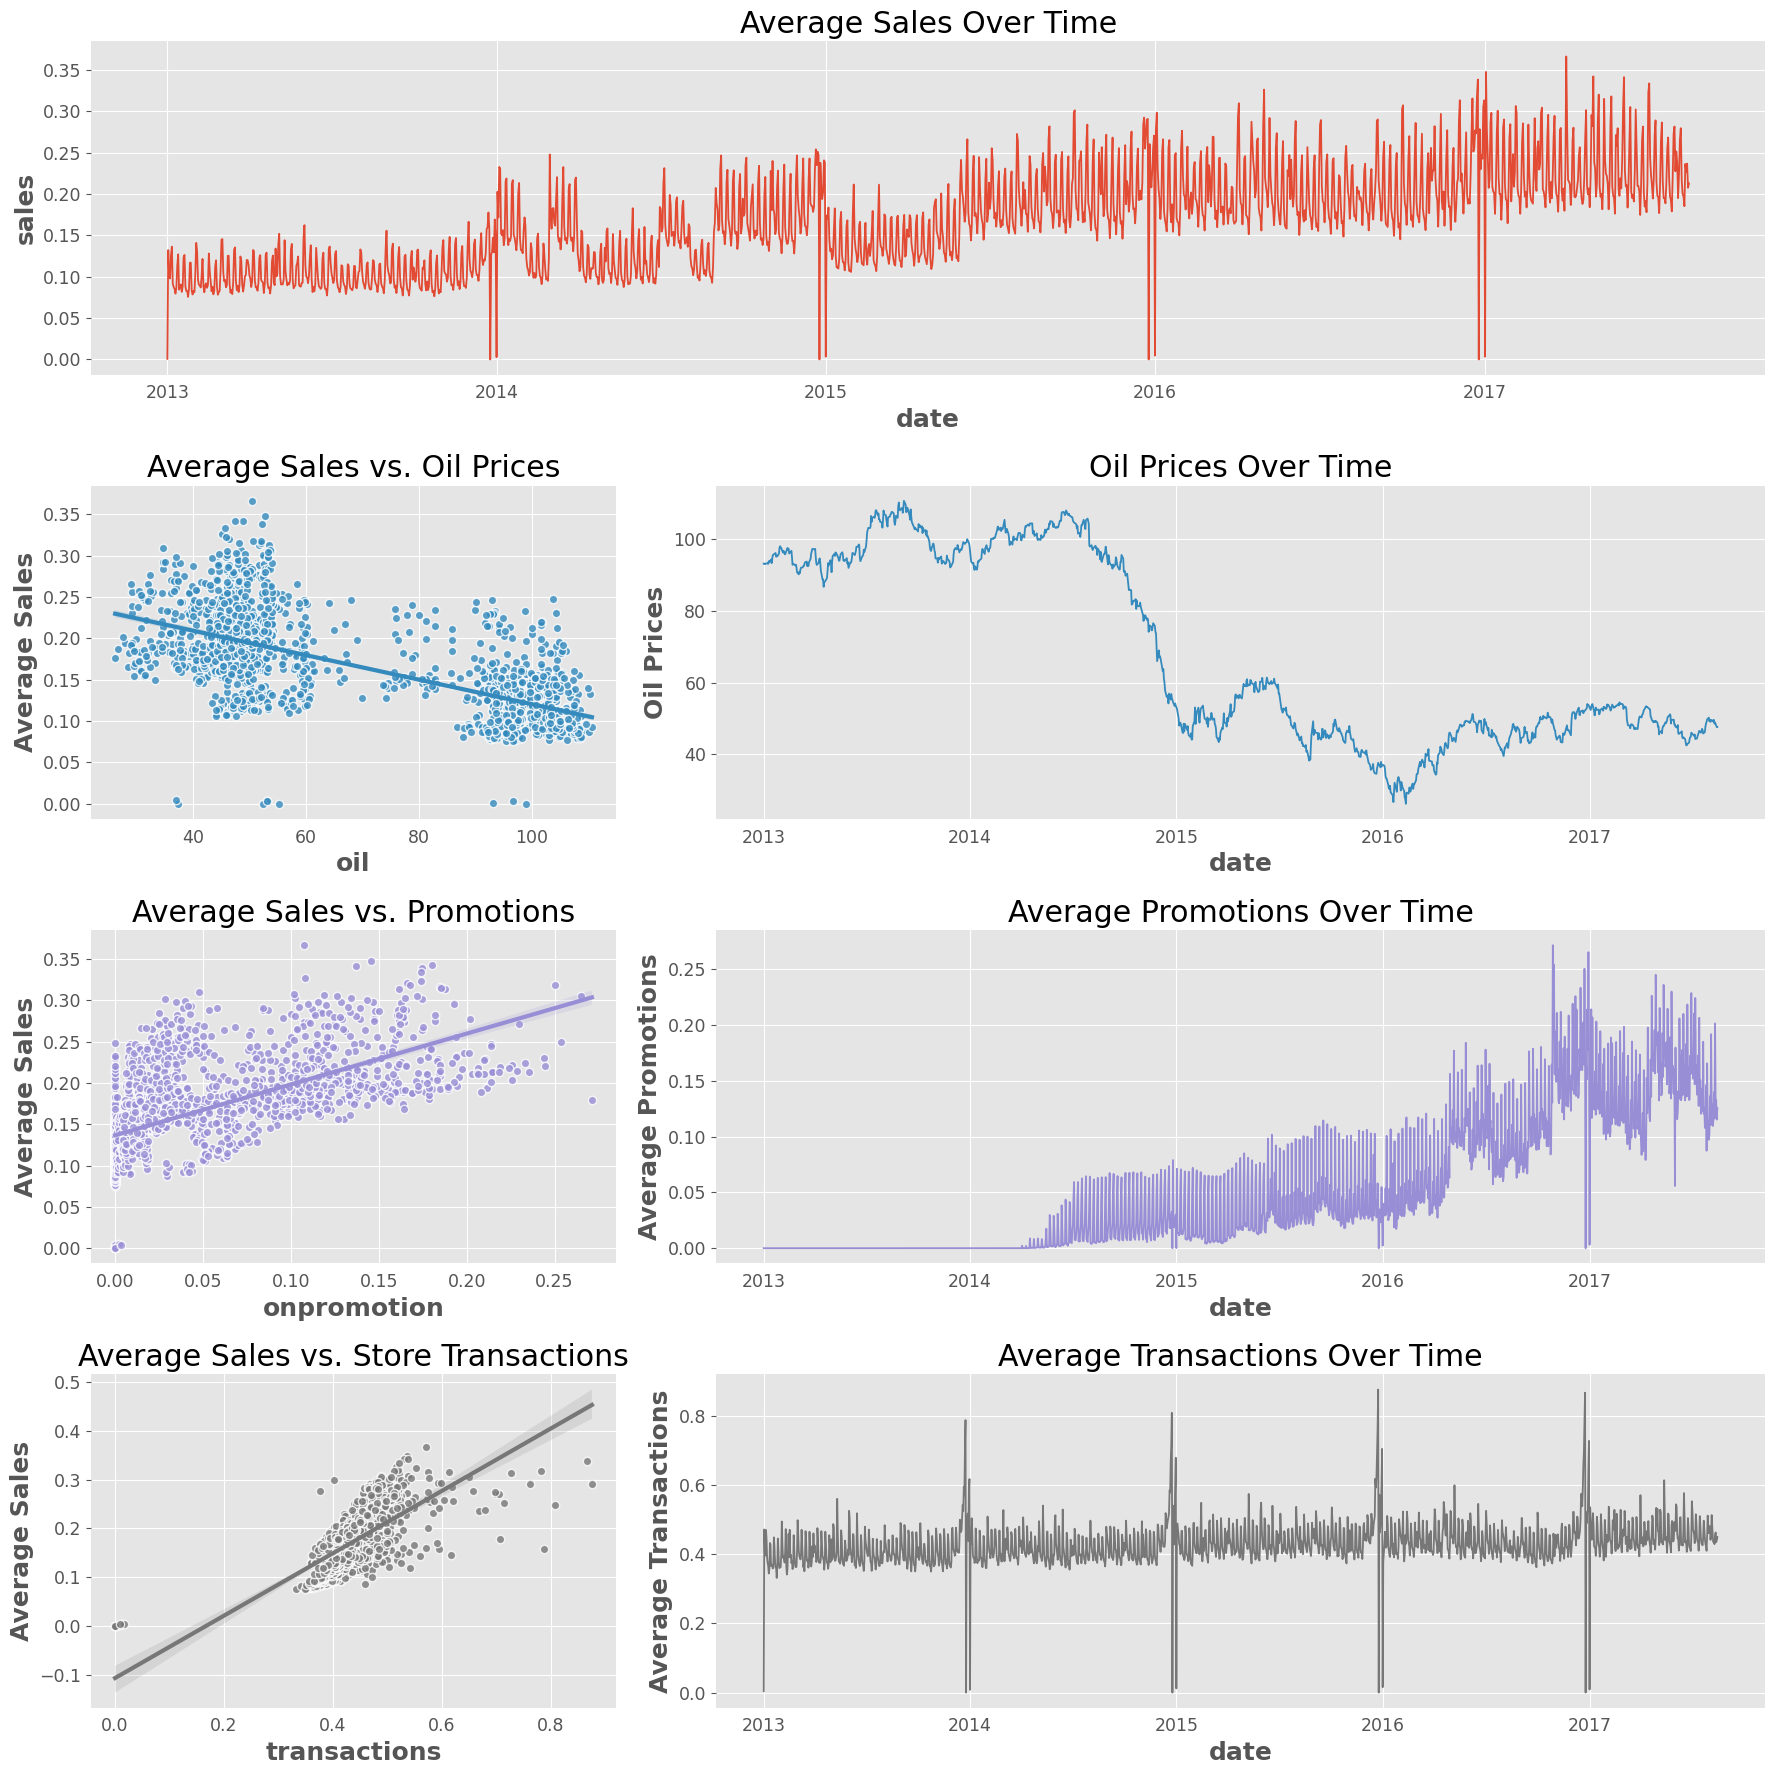

In [73]:
def plot_sales_correlation():   
    tr_ts_scaled = tr_ts.copy()
    tr_ts_scaled[tr_ts_scaled.columns] = scaler.fit_transform(tr_ts_scaled)

    promo_ts_scaled = promo_ts.copy()
    promo_ts_scaled[promo_ts_scaled.columns] = scaler.fit_transform(promo_ts_scaled)
    
    mean_sales_ts_scaled = sales_ts_scaled.mean(axis=1).to_frame("sales").reset_index()
    mean_promo_ts_scaled = promo_ts_scaled.mean(axis=1).to_frame("onpromotion").reset_index()
    mean_tr_ts_scaled = tr_ts_scaled.mean(axis=1).to_frame("transactions").reset_index()
    
    print( 
        "Covariates: oil, onpromotion, transactions",
        "Past covariates  : transactions",
        "Future covariates: oil, onpromotion",
    )

    plot_kwargs = {
        "scatter_kws": {"edgecolor": "white"},
        "line_kws": {"lw": 3},
    }
    
    fig = plt.figure(figsize=(18, 18))
    gs = fig.add_gridspec(4, 2, width_ratios=(1, 2))
    
    sns.lineplot(
        data=mean_sales_ts_scaled,
        x="date",
        y="sales",
        ax=fig.add_subplot(gs[0, :]),
    )
    plt.title("Average Sales Over Time")
    
    sns.regplot(
        x=df_oil.oil.iloc[:train_len], y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[1, 0]),
        color=COLORS[1],
        **plot_kwargs,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Oil Prices")
    
    sns.lineplot(
        data=df_oil.iloc[:train_len, :], x="date", y="oil",
        ax=fig.add_subplot(gs[1, 1]),
        color=COLORS[1],
    )
    plt.ylabel("Oil Prices")
    plt.title("Oil Prices Over Time")

    sns.regplot(
        x=mean_promo_ts_scaled.onpromotion, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[2, 0]),
        color=COLORS[2],
        **plot_kwargs,
    )
    plt.xlabel("onpromotion")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Promotions")

    sns.lineplot(
        data=mean_promo_ts_scaled, x="date", y="onpromotion",
        ax=fig.add_subplot(gs[2, 1]),
        color=COLORS[2],
    )
    plt.ylabel("Average Promotions")
    plt.title("Average Promotions Over Time")
    
    sns.regplot(
        x=mean_tr_ts_scaled.transactions, y=mean_sales_ts_scaled.sales,
        ax=fig.add_subplot(gs[3, 0]),
        color=COLORS[3],
        **plot_kwargs,
    )
    plt.xlabel("transactions")
    plt.ylabel("Average Sales")
    plt.title("Average Sales vs. Store Transactions")
    
    sns.lineplot(
        data=mean_tr_ts_scaled, x="date", y="transactions",
        ax=fig.add_subplot(gs[3, 1]),
        color=COLORS[3],
    )
    plt.ylabel("Average Transactions")
    plt.title("Average Transactions Over Time")

    plt.tight_layout()
    plt.show()
    
plot_sales_correlation()

##### Static Covariates: City, State
* Besides past and future covariates, we also have static covariates which are constant over time. The city and state columns from the store data are considered static covariates because they represent unique characteristics of the store and do not change over time. Other examples are store_nbr and family, which we have looked at earlier.

* The stacked bar chart below denotes the number of stores within each state, and the units are labeled by the corresponding store numbers. They are color-coded by each unique city within the state. Using Manabi as an example, store number 54 belongs to one city while store numbers 52, 53 belong to another city.

* We can see that most states only have one color, meaning that there are stores in only one city within each state. Some states like Guayas and Pichincha have stores in multiple cities, but the stores are dominated by one city. In other words, there may not be a noticeable difference between the city-level and state-level impacts on store sales, but this requires some experimentation later.

Static covariates: city, state Number of unique cities                      : 22 Number of unique states                      : 16 Number of states with stores in only one city: 12


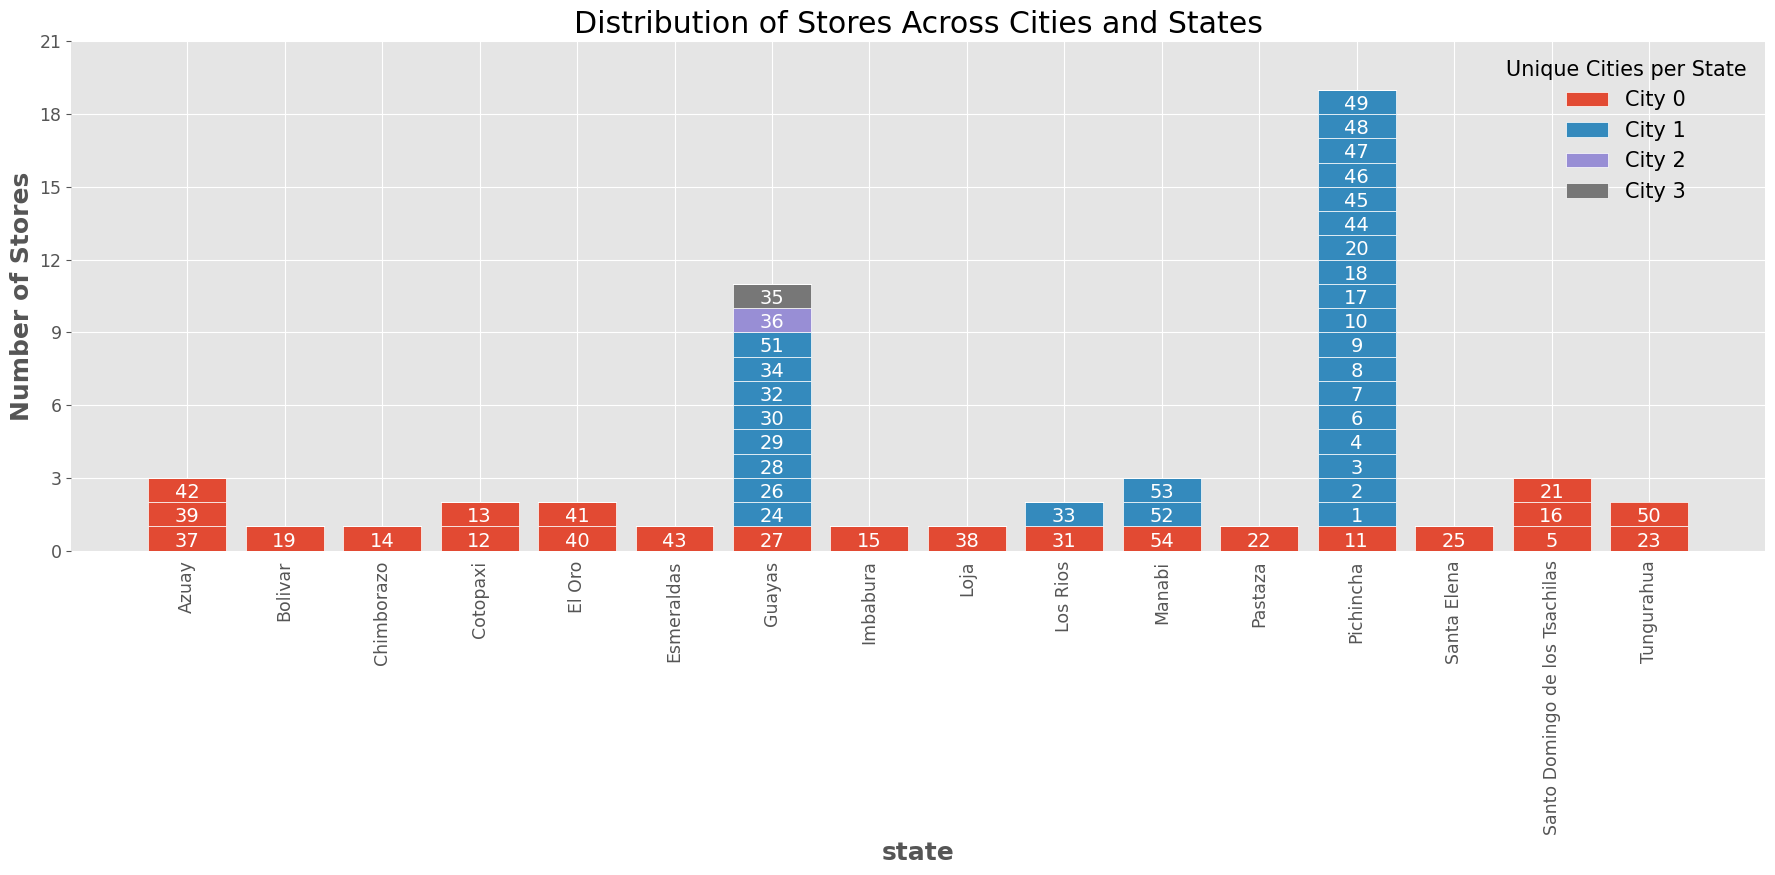

In [77]:
def plot_city_state_distribution(store):
    print(
        "Static covariates: city, state",
        f"Number of unique cities                      : {store.city.nunique()}",
        f"Number of unique states                      : {store.state.nunique()}",
        f"Number of states with stores in only one city: {(store.groupby('state').city.nunique().eq(1)).sum()}",
    )
    
    store = store.copy().sort_values(["state", "city", "store_nbr"])
    state_list = store.state.unique()
    bar_bottom = np.zeros(len(state_list))
    counter = {}

    fig = plt.figure(figsize=(18, 9))
    
    for num in store.store_nbr.unique():
        curr_state, curr_city = store.loc[store.store_nbr.eq(num), ["state", "city"]].values[0]
        if curr_state not in counter:
            counter[curr_state] = []
        if curr_city not in counter[curr_state]:
            counter[curr_state].append(curr_city)
        state_ind = (state_list==curr_state).astype(int)
        plt.bar(
            x=state_list, height=state_ind,
            bottom=bar_bottom,
            color=COLORS[len(counter[curr_state])-1],
            edgecolor="white",
            label=f"City {len(counter[curr_state])-1}",
        )
        bar_bottom += state_ind
        running_total = bar_bottom[np.argmax(state_ind)]
        plt.text(
            x=curr_state, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Unique Cities per State")
    plt.xticks(rotation=90)
    plt.yticks(list(range(0, 22, 3)))
    plt.xlabel("state")
    plt.ylabel("Number of Stores")
    plt.title("Distribution of Stores Across Cities and States")
    
    plt.tight_layout()
    plt.show()

plot_city_state_distribution(df_stores)

Finding: Most states only have stores in one city. For states with stores in multiple cities, the number of stores is generally dominated by one city. Regional Holidays in these states, cities will affect sales more than states with lower number of stores and cities.

##### Static Covariates: Type, Cluster
* The store data also has other static covariates represented by the type and cluster columns. We have another stacked bar chart which denotes the number of stores within each cluster, and the units are labeled by the corresponding store numbers. In this case, the units are color-coded by the store type that they belong to. For example, stores within clusters 1, 2, 4, 8, 9, 13 are all of the same type.

* Because most clusters only have one color, each of them are dominated by one store type. On the other hand, most store types exist in multiple clusters. This raises the possibility of cluster-level and type-level effects.

Static covariates: cluster, type Number of unique store cluster: 17 Number of unique store type   : 5


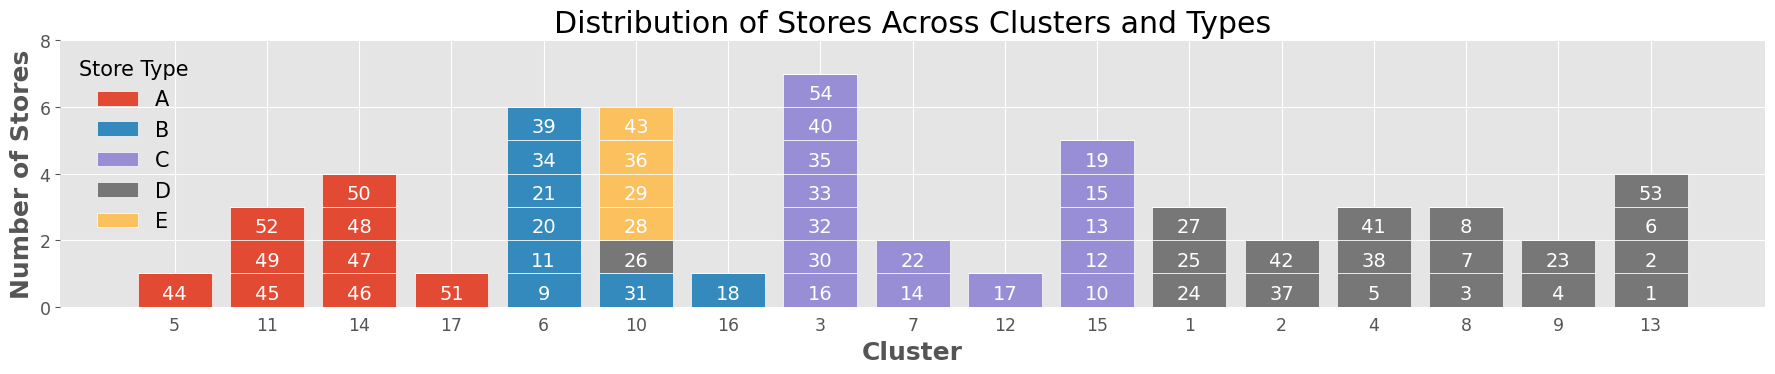

In [78]:
def plot_cluster_type_distribution(store):    
    print(
        "Static covariates: cluster, type",
        f"Number of unique store cluster: {store.cluster.nunique()}",
        f"Number of unique store type   : {store.type.nunique()}",
    )
    store = store.copy().sort_values(["type", "cluster"])
    cluster_list = store.cluster.unique().astype(str)
    type_list = store.type.sort_values().unique()
    bar_bottom = np.zeros(len(cluster_list))
    color_map = {s_type: c for s_type, c in zip(type_list, COLORS)}

    fig = plt.figure(figsize=(18, 4))
    
    for num in store.store_nbr.unique():
        curr_cluster, curr_type = store.loc[store.store_nbr.eq(num), ["cluster", "type"]].astype(str).values[0]
        cluster_ind = (cluster_list==curr_cluster).astype(int)
        plt.bar(
            x=cluster_list, height=cluster_ind,
            bottom=bar_bottom,
            zorder=2,
            color=color_map[curr_type],
            label=curr_type,
            edgecolor="white",
        )
        bar_bottom += cluster_ind
        running_total = bar_bottom[np.argmax(cluster_ind)]
        plt.text(
            x=curr_cluster, y=running_total-0.6,
            s=num,
            size=14,
            color="white",
            va="center",
            ha="center",
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = sorted(list(set(labels)))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    plt.legend(unique_handles, unique_labels, title="Store Type")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Stores")
    plt.yticks(list(range(0, 9, 2)))
    plt.title("Distribution of Stores Across Clusters and Types")
    
    plt.tight_layout()
    plt.show()
    
plot_cluster_type_distribution(df_stores)

Finding: Each cluster is dominated by one store type, and most store types have multiple clusters.

#### Sales Trends according to Date
* Date-related features like the month and year of each data point are considered future covariates because they are fixed and thus known in advance. To prevent the influence of holiday effects, we make sure to filter the data to only include non-holiday periods. We attempt to look at the distribution of sales for each covariate using boxplots. Some covariates like the days of the year have really large numbers of categories (365-366 days in a year), so inspecting that many boxplots may not be plausible. For such cases, we just compute the average sales (across all the target series) for each time period. The following date-related features are created:

    1. *Day*. With paydays being on the 15th and the last day of the month, we see that the sales tend to vary more around the same periods. In particular, this is more noticeable at the end/start of the month.
    2. *Month*. While most of the boxplots look the same, the sales tend to vary greatly in December. This could be a seasonal pattern in which people prepare early for Christmas or New Year's Day.
    3. *Year*. It is clear from the boxplots that the sales have a general upward trend across the year.
    4. *Day_of_week* Sales tend to be greater on weekends, which are non-working days for most people. It is reasonable to say that they have more time to visit the grocery stores, which translates to greater sales.
    5. *Day_of_year* / *Week_of_year*. The days of the year and weeks of the year give similar information to the months, but at different levels of granularity. To illustrate, while sales in the first week tend to be large, sales for the first day of the year is very small.
    6. *Date_index* The date index (index of the target series) gives similar information to the years, but at a higher level of granularity. There are some greater fluctuations in the first half of the time period.

Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index day                     : paydays on the 15th and last day of the month month                   : monthly seasonal patterns year                    : general trends day_of_week             : weekdays vs. weekends day_of_year/week_of_year: different levels of granularity from month date_index              : higher level of granularity than year


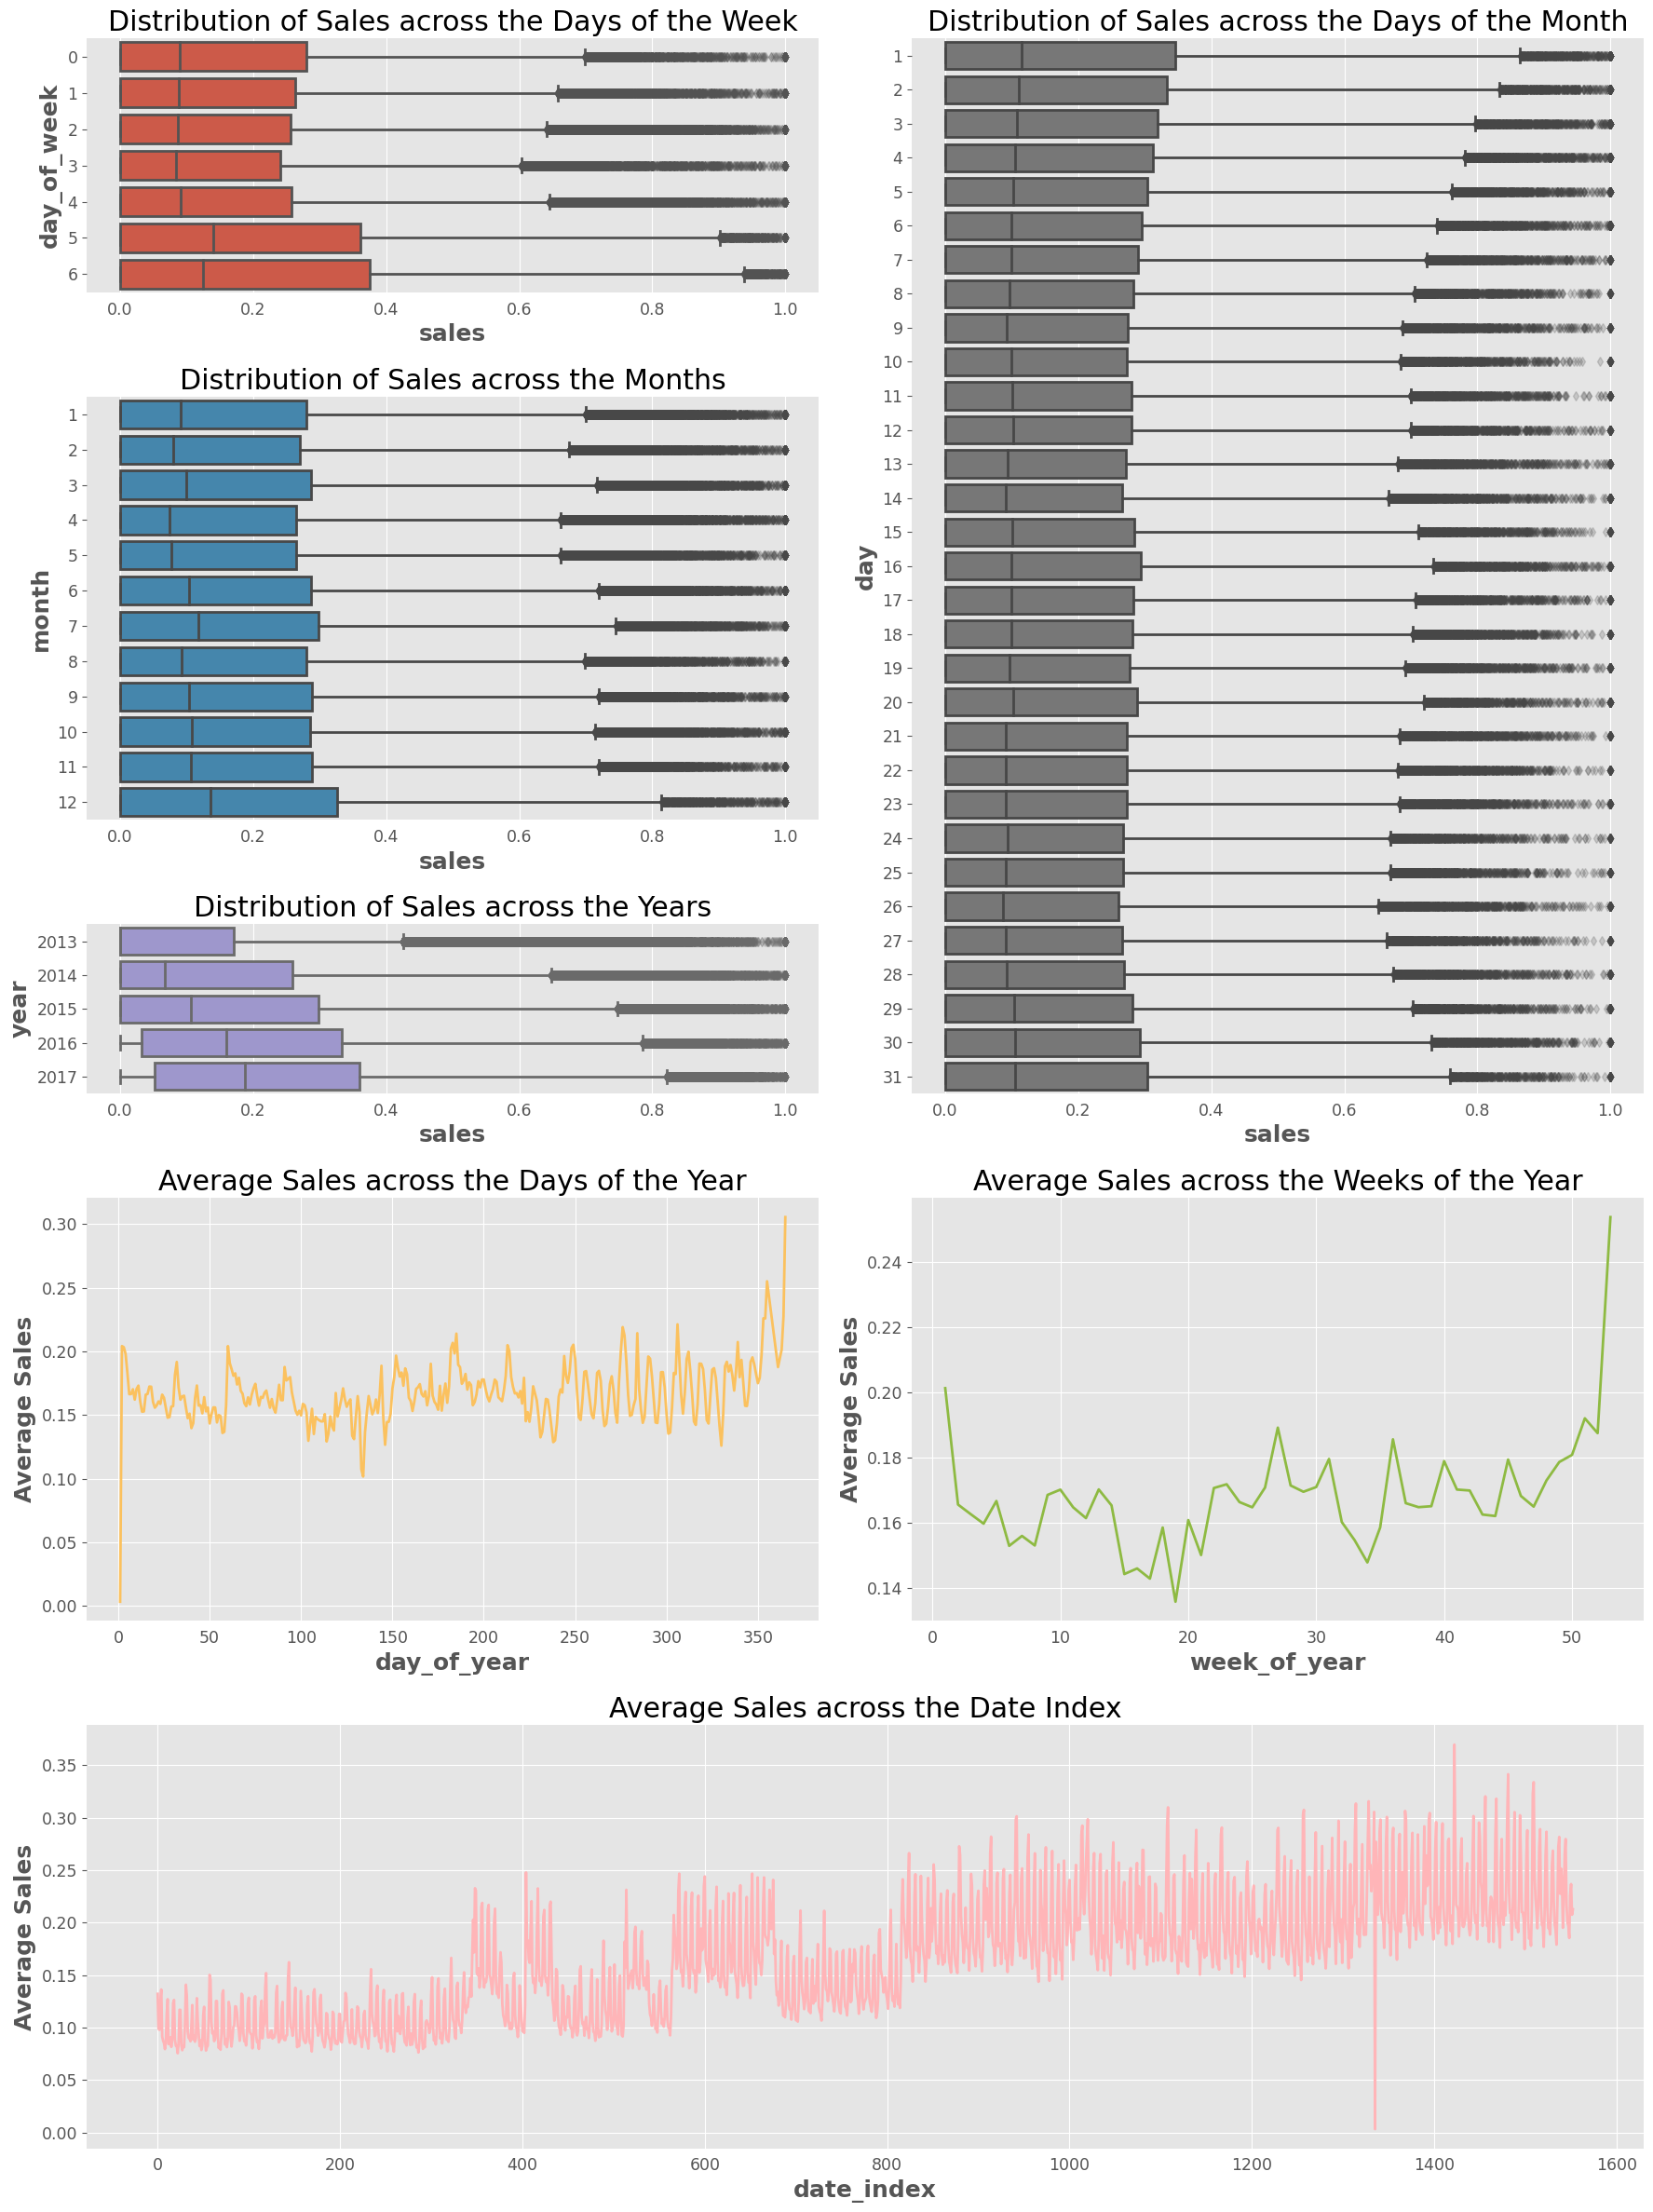

In [94]:
def plot_date_distribution():   
    df = holiday_sales_merged.copy().sort_values(["date", "store_nbr", "family"], ignore_index=True)
    df = df[df.no_holiday.eq(1)].reset_index(drop=True)
    df["day"] = df.date.dt.day
    df["month"] = df.date.dt.month
    df["year"] = df.date.dt.year
    df["day_of_week"] = df.date.dt.dayofweek
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week.astype(int)
    df["date_index"] = df.date.factorize()[0]
    
    print(
        "Future covariates: day, month, year, day_of_week, day_of_year, week_of_year, date_index",
        "day                     : paydays on the 15th and last day of the month",
        "month                   : monthly seasonal patterns",
        "year                    : general trends",
        "day_of_week             : weekdays vs. weekends",
        "day_of_year/week_of_year: different levels of granularity from month",
        "date_index              : higher level of granularity than year",
    )
    
    plot_kwargs = {
        "linewidth": 2,
        "flierprops": {"alpha": 0.2},
        "orient": "h",
    }
    
    fig = plt.figure(figsize=(18, 24))
    gs = fig.add_gridspec(5, 2, height_ratios=(3, 5, 2, 5, 5))
    
    sns.boxplot(
        data=df,
        y="day_of_week",
        x="sales",
        color=COLORS[0],
        ax=fig.add_subplot(gs[0, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Week")
    
    sns.boxplot(
        data=df,
        y="month",
        x="sales",
        color=COLORS[1],
        ax=fig.add_subplot(gs[1, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Months")
    
    sns.boxplot(
        data=df,
        y="year",
        x="sales",
        color=COLORS[2],
        ax=fig.add_subplot(gs[2, 0]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Years")
    
    sns.boxplot(
        data=df,
        y="day",
        x="sales",
        color=COLORS[3],
        ax=fig.add_subplot(gs[:3, 1]),
        **plot_kwargs,
    )
    plt.title("Distribution of Sales across the Days of the Month")
    
    sns.lineplot(
        data=df.groupby("day_of_year").sales.mean().reset_index(),
        x="day_of_year",
        y="sales",
        color=COLORS[4],
        ax=fig.add_subplot(gs[3, 0]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Days of the Year")
    
    sns.lineplot(
        data=df.groupby("week_of_year").sales.mean().reset_index(),
        x="week_of_year",
        y="sales",
        color=COLORS[5],
        ax=fig.add_subplot(gs[3, 1]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Weeks of the Year")
    
    sns.lineplot(
        data=df.groupby("date_index").sales.mean().reset_index(),
        x="date_index",
        y="sales",
        color=COLORS[6],
        ax=fig.add_subplot(gs[4, :]),
        linewidth=2,
    )
    plt.ylabel("Average Sales")
    plt.title("Average Sales across the Date Index")
    
    plt.tight_layout()
    plt.show()
    
plot_date_distribution()

Store number is a common column in both dataframes and thus we are going to merge these two dataframes so we can have info about city, state, type and cluster of similar stores in the main training dataframe.

In [17]:
df_train_merged = pd.merge(df_train, df_stores, on ='store_nbr')
df_train_merged = df_train_merged.sort_values(["store_nbr","family","date"])
df_train_merged = df_train_merged.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'str'})

display(df_train_merged.head())

,date,store_nbr,family,id,sales,onpromotion,city,state,type,cluster
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,0.0,Quito,Pichincha,D,13
33,2013-01-02,1,AUTOMOTIVE,1782.0,2.0,0.0,Quito,Pichincha,D,13
66,2013-01-03,1,AUTOMOTIVE,3564.0,3.0,0.0,Quito,Pichincha,D,13
99,2013-01-04,1,AUTOMOTIVE,5346.0,3.0,0.0,Quito,Pichincha,D,13
132,2013-01-05,1,AUTOMOTIVE,7128.0,5.0,0.0,Quito,Pichincha,D,13


Creating an array of families of products and a list of all the stores

In [18]:
family_list = df_train['family'].unique()
store_list = df_stores['store_nbr'].unique()

In [19]:
df_test_sorted = df_test.sort_values(by=['store_nbr','family'])

Next Steps:
* Initializes an empty dictionary called family_TS_dict. This dictionary will be used to store time series data for different families.
* Create a New DataFrame df_family by selecting rows from the DataFrame train_merged where the value in the 'family' column matches the current family being iterated. This effectively filters the data to include only rows related to the current family.
* Use the function **TimeSeries.from_group_dataframe** to create a list of time series objects (list_of_TS_family) from the df_family DataFrame. It uses various parameters to specify how the time series should be constructed, including the time column, group columns, static covariates, value columns, and frequency.
* Fill_missing_dates=True because in the dataset, the sales of each December 25th are missing.
* Freq='D', to indicate that the interval for the values of the time series is in days (D for day).
* Create a loop that iterates through each time series in list_of_TS_family. Inside the loop, it converts the data type of each time series (ts) to a 32-bit floating-point format (np.float32).
* Values of the TimeSeries must be interpreted in float32 and that the time series must be sorted by stores.
* Sort the list_of_TS_family based on a specific sorting criterion. The sorting key is defined using a lambda function that extracts the first value of the static covariates of each time series (ts). The sorting is performed based on integer values.
* Store the sorted list of time series for the current family in the family_TS_dict dictionary. The dictionary key is the current family name, and the value is the sorted list of time series.




In [20]:
family_TS_dict = {}

for family in family_list:
  df_family = df_train_merged.loc[df_train_merged['family'] == family]

  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                static_cols=["city","state","type","cluster"],
                                value_cols="sales",
                                fill_missing_dates=True,
                                freq='D')
  for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[family] = list_of_TS_family

### Darts Time-Series Object
* We have now created a timeseries Object using the TimeSeries class for each product family for each store.
e.g. if we display family_TS_dict's AUTOMOTIVE key and then call the 0 value, we are effectively pointing to the Time-Series of Automotive family of products of Store '1'.
* This timeseries gives us all the sales and its date as indexes and then attached with it as static covariates are all the rest of the attributes of the sale i.e. Store number, product family, city, state, cluster.
* This time-series object is the main advantage of the darts library and allows us to use various deep learning and machine learning algorithms seamlessly
* Find out more about this object [here](https://unit8co.github.io/darts/generated_api/darts.timeseries.html?highlight=timeseries)

In [21]:
# First Time Series of the first family
display(family_TS_dict['AUTOMOTIVE'][0])

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)>
array([[[0.]],

       [[2.]],

       [[3.]],

       ...,

       [[1.]],

       [[1.]],

       [[4.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates store_nbr      family   city      s...
    hierarchy:          None

# Data Pre-Processing
### Normalizing the Time-Series Objects and One-Hot Encoding its covariates
* Normalization is a technique used to improve the performance of a Machine Learning model by facilitating its training. [Read More](https://inside-machinelearning.com/en/normalize-your-data/)

* We will use the *Scaler* function of darts to normalize.

* We further optimize the training of the model by one hot encoding our covariates via the *StaticCovariatesTransformer* function.
* We used the *MissingValuesFiller* class to fill missing values
* We used *InvertibleMapper* class to >>>>
* Used a for loop to apply each of the above transformations using *fit.transform* method
* Stored the transformed time-series into family_TS_transformed_dict

In [22]:


family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in family_TS_dict:
  train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = sklearn.preprocessing.OneHotEncoder(), name="Encoder")
  log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
  train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])
     
  training_transformed = train_pipeline.fit_transform(family_TS_dict[key])
  family_pipeline_dict[key] = train_pipeline
  family_TS_transformed_dict[key] = training_transformed

We can check the transformations by displaying again

In [23]:
family_TS_transformed_dict['AUTOMOTIVE'][0]

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.36672579]],

       [[0.46275643]],

       ...,

       [[0.23137821]],

       [[0.23137821]],

       [[0.53724357]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr_1  store_nbr_10  store_n...
    hierarchy:          None

## Covariates
* In general terms, covariates are characteristics (excluding the actual treatment) of the participants in an experiment. If you collect data on characteristics before you run an experiment, you could use that data to see how your treatment affects different groups or populations. Or, you could use that data to control for the influence of any covariate.
* Covariates can be dependent on the target variable. For example, the type of store, type, where the sales are made. But it can also be independent. For example, the price of oil on the day of the sale of a product.
* Covariate can be known in advance, for example in our dataset we have the Date which is known in advance. In this case, we talk about a **future covariate**.
* There are also past covariates that are not known in advance. For example in our dataset, the transactions are known for the dates January 1, 2013 to August 15, 2017.

##### Date
* The first covariate we are interested in is the date. The date is a future covariate because we know the date of the coming days.
* It has, in many cases, an impact on the traffic of a store. For example, we can expect that on Saturday there will be more customers in the store than on Monday. But it can also be expected that during the summer vacations the store will be less busy than in normal times. Hence every little detail counts.
* In order not to miss anything, we will extract as much information as possible from this date. Here, 7 columns :
    * year – year
    * month – month
    * day – day
    * dayofyear – day of the year (for example February 1 is the 32nd day of the year)
    * weekday – day of the week (there are 7 days in a week)
    * weekofyear – week of the year (there are 52 weeks in a year)
    * linear_increase – the index of the interval
* Fortunately the darts library enables us to extract all these details from the date column using the *datetime_attribute_timeseries* function.
* We use the *stack method* to create a heirarcy of these attributes.
* We create a time-series using all this data and store it in time_cov

In [24]:
full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')


year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                             values=np.arange(len(full_time_period)),
                                             columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

In [25]:
print(time_cov.components.values)
time_cov[1]

['year' 'month' 'day' 'dayofyear' 'dayofweek' 'weekofyear'
 'linear_increase']


<TimeSeries (DataArray) (time: 1, component: 7, sample: 1)>
array([[[2.013e+03],
        [1.000e+00],
        [2.000e+00],
        [2.000e+00],
        [2.000e+00],
        [1.000e+00],
        [1.000e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-02
  * component  (component) object 'year' 'month' ... 'linear_increase'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

And of course, we will normalize this data as well:

In [26]:
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)

In [27]:
time_cov_transformed[1]

<TimeSeries (DataArray) (time: 1, component: 7, sample: 1)>
array([[[0.        ],
        [0.        ],
        [0.03333334],
        [0.00273973],
        [0.33333334],
        [0.        ],
        [0.00059277]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-02
  * component  (component) object 'year' 'month' ... 'linear_increase'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

You can also see that a split is made between the dates before August 15, 2017 and after (dates that will be used in the prediction).

##### Oil
* Here, we will not simply extract the daily oil price but we will calculate the moving average.
* The moving average in X, is an average of the current value and the X-n previous values of a time series.
* For example the moving average in 7 is the average of (t + t-1 + … + t-6) / 7. It is calculated at each t, that’s why it is called “moving”.
* Calculating the moving average allows us to remove the momentary fluctuations of a value and thus to accentuate the long-term trends.
* The moving average is used in trading, but more generally in Time Series Analysis.
* In the following code, we calculate the moving average in 7 and 28 of the oil price. And of course, we apply a normalization
* Darts provides us with the MovingAverage class to calculate moving averages.

In [29]:

# Oil Price

oil = TimeSeries.from_dataframe(df_oil, 
                                time_col = 'date', 
                                value_cols = ['oil'],
                                freq = 'D')

oil = oil.astype(np.float32)

# Transform
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
oil_pipeline = Pipeline([oil_filler, oil_scaler])
oil_transformed = oil_pipeline.fit_transform(oil)

# Moving Averages for Oil Price
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_28 = MovingAverageFilter(window=28)

oil_moving_averages = []

ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)

In [30]:
oil_moving_averages[100]

<TimeSeries (DataArray) (date: 1, component: 2, sample: 1)>
array([[[0.78416604],
        [0.78240633]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 2013-04-11
  * component  (component) object 'oil_ma_7' 'oil_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### Holidays
Let’s now focus on the holidays.

Here, Ferdinand Berr has implemented functions to detail these holidays. In particular, he adds information about whether the holiday is Christmas day, whether it is a soccer game day, etc:

In [31]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [32]:
df_holidays_events.head(20)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [33]:
def holiday_list(df_stores, df_holidays_events):

    listofseries = []
    #creating an array of dataframes for the holidays for each store
    for i in range(0,len(df_stores)):
            
            df_holiday_dummies = pd.DataFrame(columns=['date']) # created an empty dataframe with only date column
            df_holiday_dummies["date"] = df_holidays_events["date"] # equated that date column to the date column of holiday_events
            
            #if its a national holiday it will be marked as 1 in the national holiday column, similar approach for other holidays
            df_holiday_dummies["national_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & 
                                                               (df_holidays_events["locale"] == "National")), 1, 0) 

            df_holiday_dummies["earthquake_relief"] = np.where(df_holidays_events['description'].str.contains('Terremoto Manabi'), 1, 0)

            df_holiday_dummies["christmas"] = np.where(df_holidays_events['description'].str.contains('Navidad'), 1, 0)

            df_holiday_dummies["football_event"] = np.where(df_holidays_events['description'].str.contains('futbol'), 1, 0)

            df_holiday_dummies["national_event"] = np.where(((df_holidays_events["type"] == "Event") & 
                                                             (df_holidays_events["locale"] == "National") & 
                                                             (~df_holidays_events['description'].str.contains('Terremoto Manabi')) & 
                                                             (~df_holidays_events['description'].str.contains('futbol'))), 1, 0)

            df_holiday_dummies["work_day"] = np.where((df_holidays_events["type"] == "Work Day"), 1, 0)

            # for local, regional holiday its locale name should match the current store's state or city. 
            df_holiday_dummies["local_holiday"] = np.where(((df_holidays_events["type"] == "Holiday") & 
                                                            ((df_holidays_events["locale_name"] == df_stores['state'][i]) | 
                                                             (df_holidays_events["locale_name"] == df_stores['city'][i]))), 1, 0)
                     
            listofseries.append(df_holiday_dummies)
    # retirning a list of all the series for each store
    return listofseries

In [34]:
def remove_0_and_duplicates(store_holiday_dataframes):
    """ Remove 0s and duplicate values from all timeseries we created with the holiday_list function """
    listofseries = []
    
    for i in range(0,len(store_holiday_dataframes)):
            
            df_holiday_per_store = store_holiday_dataframes[i].set_index('date')

            df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]
            
            df_holiday_per_store = df_holiday_per_store.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                                   'christmas':'max', 'football_event':'max', 
                                   'national_event':'max', 'work_day':'max', 
                                   'local_holiday':'max'}).reset_index()

            listofseries.append(df_holiday_per_store)

    return listofseries


A function to create time series objects for each store's holiday database and put them all in a list

In [35]:
def holiday_TS_list_54(store_holiday_dataframes):
    """ Create Timeseries from dataframes of holidays for each store and 
    then output an array of these timeseries objects"""    
    listofseries = []
    
    for i in range(0,54):
            
            holidays_TS = TimeSeries.from_dataframe(store_holiday_dataframes[i], 
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')
            
            holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))
            holidays_TS = holidays_TS.astype(np.float32)
            listofseries.append(holidays_TS)

    return listofseries

Applying these functions

In [36]:
store_holiday_dataframes = holiday_list(df_stores, df_holidays_events)
store_holiday_dataframes = remove_0_and_duplicates(store_holiday_dataframes)   
list_of_holidays_store = holiday_TS_list_54(store_holiday_dataframes)

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)

We get 54 TimeSeries with 7 columns:

* national_holiday
* earthquake_relief
* christmas
* football_event
* national_event
* work_day
* local_holiday

In [37]:
display(len(holidays_transformed))
display(holidays_transformed[0].components.values)
display(holidays_transformed[0][100])

54

array(['national_holiday', 'earthquake_relief', 'christmas',
       'football_event', 'national_event', 'work_day', 'local_holiday'],
      dtype=object)

<TimeSeries (DataArray) (date: 1, component: 7, sample: 1)>
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 2013-04-11
  * component  (component) object 'national_holiday' ... 'local_holiday'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### Promotion
The last future covariate to process is the onpromotion column.

It gives us the number of items on promotion in a product family.

Here the code is similar to the one used for the sales column. It allows to extract for each family, the time series of the 54 stores:

In [38]:
df_promotion = pd.concat([df_train, df_test], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])
df_promotion.tail()

family_promotion_dict = {}

for family in family_list:
  df_family = df_promotion.loc[df_promotion['family'] == family]

  list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                value_cols="onpromotion",
                                fill_missing_dates=True,
                                freq='D')
  
  for ts in list_of_TS_promo:
    ts = ts.astype(np.float32)

  family_promotion_dict[family] = list_of_TS_promo

In [39]:
family_promotion_dict['AUTOMOTIVE'][2]

<TimeSeries (DataArray) (date: 1704, component: 1, sample: 1)>
array([[[0.]],

       [[0.]],

       [[0.]],

       ...,

       [[0.]],

       [[0.]],

       [[0.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-31
  * component  (component) object 'onpromotion'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr      family\ncomponent  ...
    hierarchy:          None

Let’s go further by calculating also the moving average in 7 and 28, like for the oil price:

In [40]:

promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
  promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
  promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

  promo_pipeline = Pipeline([promo_filler,
                             promo_scaler])
  
  promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])
  
  # Moving Averages for Promotion Family Dictionaries
  promo_moving_average_7 = MovingAverageFilter(window=7)
  promo_moving_average_28 = MovingAverageFilter(window=28)

  promotion_covs = []

  for ts in promotion_transformed:
    ma_7 = promo_moving_average_7.filter(ts)
    ma_7 = TimeSeries.from_series(ma_7.pd_series())  
    ma_7 = ma_7.astype(np.float32)
    ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
    ma_28 = promo_moving_average_28.filter(ts)
    ma_28 = TimeSeries.from_series(ma_28.pd_series())  
    ma_28 = ma_28.astype(np.float32)
    ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
    promo_and_mas = ts.stack(ma_7).stack(ma_28)
    promotion_covs.append(promo_and_mas)

  promotion_transformed_dict[key] = promotion_covs

100%|██████████| 33/33 [00:32<00:00,  1.01it/s]


We obtain a normalized time series with 3 columns.

We can display the index 1 of the first TimeSeries of the first family:

In [41]:
promotion_transformed_dict['AUTOMOTIVE'][0].components.values


array(['onpromotion', 'promotion_ma_7', 'promotion_ma_28'], dtype=object)

In [42]:
promotion_transformed_dict['AUTOMOTIVE'][0][1]

<TimeSeries (DataArray) (date: 1, component: 3, sample: 1)>
array([[[0.],
        [0.],
        [0.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-02
  * component  (component) object 'onpromotion' ... 'promotion_ma_28'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store_nbr      family\nglobal_comp...
    hierarchy:          None

##### Grouping the covariates
To finish with the future covariates, we are going to gather them in the same TimeSeries.

We start with the time series of the dates, the oil price and the moving averages of the oil price that we group in the variable general_covariates :



In [43]:
general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

We use the stack method which stacks two multivariate timeseries together and the returns a new series for each store. We slap together the TimeSeries of the holidays with the general_covariates :

In [44]:
store_covariates_future = []

for store in range(0,len(store_list)):
  stacked_covariates = holidays_transformed[store].stack(general_covariates)  
  store_covariates_future.append(stacked_covariates)

Finally, for each family, we combine the previously created covariates with the promotion covariates:

In [45]:
future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

  promotion_family = promotion_transformed_dict[key]
  covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0,len(promotion_family))]

  future_covariates_dict[key] = covariates_future

100%|██████████| 33/33 [00:03<00:00, 10.90it/s]


Here are the different columns obtained for each TimeSeries of each family of each store:

In [46]:
future_covariates_dict['AUTOMOTIVE'][0].components

Index(['onpromotion', 'promotion_ma_7', 'promotion_ma_28', 'national_holiday',
       'earthquake_relief', 'christmas', 'football_event', 'national_event',
       'work_day', 'local_holiday', 'year', 'month', 'day', 'dayofyear',
       'dayofweek', 'weekofyear', 'linear_increase', 'oil', 'oil_ma_7',
       'oil_ma_28'],
      dtype='object', name='component')

##### Transactions – Past Covariates
Before launching the training of the model, let’s extract the past covariates: the transactions.

As you might already have understand, after having taken the transactions for each store, we will normalize them:

In [47]:
df_transactions.sort_values(["store_nbr","date"], inplace=True)

TS_transactions_list = TimeSeries.from_group_dataframe(
                                df_transactions,
                                time_col="date",
                                group_cols=["store_nbr"],
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []

for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())
            series = series.astype(np.float32)
            transactions_list.append(series)

transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))


transactions_list_full = []

for ts in transactions_list:
  if ts.start_time() > pd.Timestamp('20130101'):
    end_time = (ts.start_time() - timedelta(days=1))
    delta = end_time - pd.Timestamp('20130101')
    zero_series = TimeSeries.from_times_and_values(
                              times=pd.date_range(start=pd.Timestamp('20130101'), 
                              end=end_time, freq="D"),
                              values=np.zeros(delta.days+1))
    ts = zero_series.append(ts)
    ts = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions")
    transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

In [48]:
transactions_transformed[0]

<TimeSeries (DataArray) (time: 1688, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.69831293]],

       [[0.60635131]],

       ...,

       [[0.13761164]],

       [[0.57327158]],

       [[0.5600397 ]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'transactions'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
LGBM_Models_Submission = {}

display("Training...")

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family] 
  TCN_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  LGBM_Model_Submission = LightGBMModel(lags = 63,
                                        lags_future_covariates = (14,1),
                                        lags_past_covariates = [-16,-17,-18,-19,-20,-21,-22],
                                        output_chunk_length=1,
                                        random_state=2022,
                                        gpu_use_dp= "false",
                                        )
     
  LGBM_Model_Submission.fit(series=train_sliced, 
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed)

  LGBM_Models_Submission[family] = LGBM_Model_Submission

'Training...'

100%|██████████| 33/33 [02:23<00:00,  4.35s/it]


##### Predict
We can now perform the predictions:

In [ ]:
display("Predictions...")

LGBM_Forecasts_Families_Submission = {}

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family]
  LGBM_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  forecast_LGBM = LGBM_Models_Submission[family].predict(n=16,
                                         series=train_sliced,
                                         future_covariates=LGBM_covariates,
                                         past_covariates=transactions_transformed)
  
  LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

'Predictions...'

100%|██████████| 33/33 [00:11<00:00,  2.93it/s]


Note: even if the model has an output_chunk_length of 1, we can directly instruct it to predict 16 values in the future.

We now have our predictions. If you follow well, you know the next step.

Previously, we normalized our data with the Scaler function. So the predicted data are also normalized.

To de-normalize them we use the inverse_transform function on each TimeSeries:

In [ ]:
LGBM_Forecasts_Families_back_Submission = {}

for family in tqdm(family_list):

  LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)

100%|██████████| 33/33 [00:14<00:00,  2.25it/s]


Finally, here is the code that allows to go from the predicted time series cluster to the prediction DataFrame:

In [44]:
# extraxting all time series for each family of products for each store and creating a list of resulting pandas dataframes
for family in tqdm(LGBM_Forecasts_Families_back_Submission):
  for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
    if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
        LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)

listofseries = []

for store in tqdm(range(0,54)):
  for family in family_list:
      oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
      oneforecast.columns = ['fcast']
      listofseries.append(oneforecast)

df_forecasts = pd.concat(listofseries) 
df_forecasts.reset_index(drop=True, inplace=True)

# No Negative Forecasts
df_forecasts[df_forecasts < 0] = 0

#putting the predeictions in kaggle submissions format
forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family', 'onpromotion'], axis=1)
forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

# Submission
submission_kaggle = forecasts_kaggle_sorted

100%|██████████| 54/54 [00:00<00:00, 137.26it/s]


In [45]:
submission_kaggle.head()

,id,sales
0,3000888,3.137218
1,3000889,0.000000
2,3000890,4.041873
3,3000891,2276.543092
4,3000892,0.039745


##### Multiple models
Now we need to train several models and apply the Ensemble method to improve our predictions. 

As explained before, the important thing in this code is the hyperparameters. We will train 3 different models by taking the following hyperparameters but each of them will have multiple models for each product family.

In [46]:
model_params = [
    {"lags" : 7, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 365, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 730, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}
]

In [49]:
submission_kaggle_list = []

for params in model_params:

  LGBM_Models_Submission = {}

  display("Training...")

  for family in tqdm(family_list):

    # Define Data for family
    sales_family = family_TS_transformed_dict[family]
    training_data = [ts for ts in sales_family] 
    TCN_covariates = future_covariates_dict[family]
    train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

    LGBM_Model_Submission = LightGBMModel(lags = params["lags"],
                                          lags_future_covariates = params["lags_future_covariates"],
                                          lags_past_covariates = params["lags_past_covariates"],
                                          output_chunk_length=1,
                                          random_state=2022,
                                          gpu_use_dp= "false")
      
    LGBM_Model_Submission.fit(series=train_sliced, 
                          future_covariates=TCN_covariates,
                          past_covariates=transactions_transformed)

    LGBM_Models_Submission[family] = LGBM_Model_Submission
    
  display("Predictions...")


  LGBM_Forecasts_Families_Submission = {}

  for family in tqdm(family_list):

    sales_family = family_TS_transformed_dict[family]
    training_data = [ts for ts in sales_family]
    LGBM_covariates = future_covariates_dict[family]
    train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

    forecast_LGBM = LGBM_Models_Submission[family].predict(n=16,
                                          series=train_sliced,
                                          future_covariates=LGBM_covariates,
                                          past_covariates=transactions_transformed)
    
    LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

  # De-Normalizing 

  LGBM_Forecasts_Families_back_Submission = {}

  for family in tqdm(family_list):

    LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)

  # Prepare Submission in Correct Format

  for family in tqdm(LGBM_Forecasts_Families_back_Submission):
    for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
      if (family_TS_dict[family][n].univariate_values()[-21:] == 0).all():
          LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)
          
  listofseries = []

  for store in tqdm(range(0,54)):
    for family in family_list:
        oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
        oneforecast.columns = ['fcast']
        listofseries.append(oneforecast)

  df_forecasts = pd.concat(listofseries) 
  df_forecasts.reset_index(drop=True, inplace=True)

  # No Negative Forecasts
  df_forecasts[df_forecasts < 0] = 0
  forecasts_kaggle = pd.concat([df_test_sorted, df_forecasts.set_index(df_test_sorted.index)], axis=1)
  forecasts_kaggle_sorted = forecasts_kaggle.sort_values(by=['id'])
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.drop(['date','store_nbr','family'], axis=1)
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.rename(columns={"fcast": "sales"})
  forecasts_kaggle_sorted = forecasts_kaggle_sorted.reset_index(drop=True)

  # Submission
  submission_kaggle_list.append(forecasts_kaggle_sorted)

'Training...'

100%|██████████| 33/33 [02:17<00:00,  4.16s/it]


'Predictions...'

100%|██████████| 54/54 [00:00<00:00, 121.25it/s]


'Training...'

100%|██████████| 33/33 [04:33<00:00,  8.28s/it]


'Predictions...'

100%|██████████| 54/54 [00:00<00:00, 144.11it/s]


'Training...'

100%|██████████| 33/33 [05:55<00:00, 10.76s/it]


'Predictions...'

100%|██████████| 54/54 [00:00<00:00, 137.74it/s]


We end up with four prediction DataFrames that we will sum and average (this is the so-called ensemble method):

In [50]:
df_sample_submission['sales'] = (submission_kaggle[['sales']]+submission_kaggle_list[0][['sales']]+submission_kaggle_list[1][['sales']]+submission_kaggle_list[2][['sales']])/4

In [51]:
df_sample_submission.head()

,id,sales
0,3000888,3.391998
1,3000889,0.000000
2,3000890,4.367087
3,3000891,2255.160117
4,3000892,0.025445
